In [1]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.density_estimation import XDGMM
from sklearn.mixture import GaussianMixture
import fitsio as fio
import glob
import os
import math
import matplotlib.colors as clr
from scipy import interpolate
from scipy.optimize import minimize
from scipy import optimize
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [2]:
Roman_truth_file = '/global/cscratch1/sd/zg64/Rubin-Roman-Redmagic/dc2_truth_gal_icrs.fits'
aa = fio.FITS(Roman_truth_file)[-1]
Roman_z = aa.read_column('z')

Roman_output_dir = '/global/cscratch1/sd/zg64/Rubin-Roman-Redmagic/dc2_sim_output/'
Roman_match_files = np.sort(glob.glob(os.path.join(Roman_output_dir,'*.fits')))
roman_truth = fio.FITS(Roman_match_files[1])[-1].read()
roman_detection = fio.FITS(Roman_match_files[0])[-1].read()

In [3]:
# Load Seed LRGs
Red_gal_ind = np.load('data/roman_seed_lrg.npy')
roman_ind = roman_truth['ind']
matched_inds_in_truth = roman_ind[Red_gal_ind]

zs = Roman_z[matched_inds_in_truth]
measured_qts = roman_detection[Red_gal_ind]

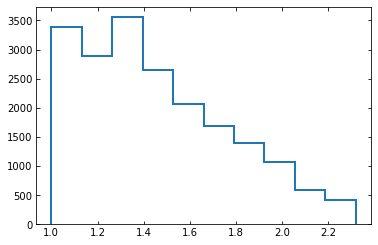

In [4]:
plt.hist(zs,histtype='step',linewidth = 2);

In [5]:
def get_vals (c1,c2,ref_m,z_mask):
    fz = 20
    mag_c1 = measured_qts['mag_auto_%s'%c1][z_mask]
    mag_c2 = measured_qts['mag_auto_%s'%c2][z_mask]
    mag_ref = measured_qts['mag_auto_%s'%ref_m][z_mask]
    
    color = mag_c1-mag_c2
    
    mag_c1_err = measured_qts['magerr_auto_%s'%c1][z_mask]
    mag_c2_err = measured_qts['magerr_auto_%s'%c2][z_mask]
    

    color_err = (mag_c1_err**2 + mag_c2_err**2)
    return(np.mean(mag_ref),mag_ref,color,color_err)

In [73]:
def plot_model(ax,mag_ref,m_ref_mean,res,c1,c2):
    ax.plot(mag_ref-m_ref_mean,color,'.',label = 'Seed LRGs')
    xx = mag_ref-m_ref_mean
    xx.sort()
    yy = res[0] + res[1]*(xx)
    ax.plot(xx,yy,color = 'red',label = 'Model');
    sigma = np.sqrt(res[2])
    ax.fill_between(xx,(yy-sigma),(yy+sigma),color = 'red',alpha = 0.25,label = r'$1\sigma$')
    ax.fill_between(xx,(yy-sigma*2),(yy+sigma*2),alpha = 0.15,label = r'$2\sigma$')
    ax.set_ylim(yy.mean()-0.5,yy.mean()+0.5)
    ax.set_ylabel('%s - %s'%(c1,c2),fontsize = 15)
    ax.legend(loc = 'best',fontsize = 13,frameon = False)
    ax.set_xlabel('Magnitude',fontsize = 15)

In [8]:
def func (x):
    a,b,sigma_int = x
    #a,b = x
    vals = np.zeros(shape = mag_ref.shape)
    for i,m_f in enumerate(mag_ref):
        
        c_model = a + b * (m_f - m_ref_mean)
        
        sigma_photo = color_err[i]
        
        c_gal = color[i]
        
        sigma_tot =sigma_photo + sigma_int
        
        single_gal = (c_gal - c_model)**2*(1/sigma_tot) + math.log((2*np.pi)**3*sigma_tot)
        
        vals[i] = single_gal
        
    return(np.sum(vals))

Optimization terminated successfully.
         Current function value: 1512.781217
         Iterations: 80
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 770.010659
         Iterations: 106
         Function evaluations: 188


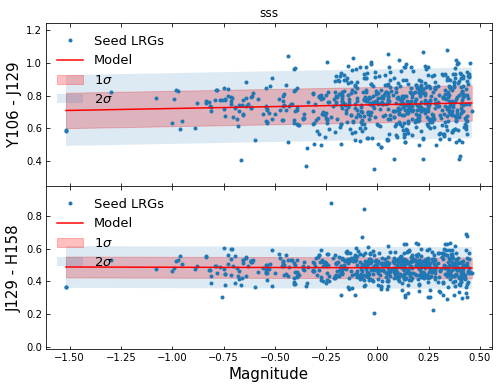

In [81]:
fr = ['Y106','J129','H158','F184']
z_low = 1.7
z_high = z_low + 0.05
z_mask = (zs > z_low) & (zs < z_high)

f,ax = plt.subplots(2,1,figsize = (8,6))
ax[0].set_title('sss')
plt.subplots_adjust(hspace=0.0)
m_ref_mean,mag_ref,color,color_err = get_vals(c1 = fr[0],c2 = fr[1],ref_m=fr[-1],z_mask=z_mask)
x0 = (1,0.5,0.002)
res = optimize.fmin(func, x0);
plot_model(ax = ax[0], mag_ref=mag_ref,m_ref_mean=m_ref_mean,res=res,c1=fr[0],c2 = fr[1])

m_ref_mean,mag_ref,color,color_err = get_vals(c1 = fr[1],c2 = fr[2],ref_m=fr[-1],z_mask=z_mask)
x0 = (1,0.5,0.002)
res = optimize.fmin(func, x0);
plot_model(ax = ax[1], mag_ref=mag_ref,m_ref_mean=m_ref_mean,res=res,c1=fr[1],c2 = fr[2])

In [ ]:
x0 = (1,0.5,0.02)
res = minimize(func, x0,method='BFGS',bounds=((None,None),(None,None),(0.01,0.2)))